In [1]:
# imports
import torch
import torch.nn as nn
import math
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from dataset import dataset
from model import pressureInsolesTransformer
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [14]:
# Dataloading
#path_list = ['../data_interpolate/subject1.pth', '../data_interpolate/subject2.pth', '../data_interpolate/subject3.pth', '../data_interpolate/subject4.pth', '../data_interpolate/subject5.pth',
#                        '../data_interpolate/subject6.pth', '../data_interpolate/subject7.pth', '../data_interpolate/subject8.pth', '../data_interpolate/subject9.pth', '../data_interpolate/subject10.pth']
path_list = ['../data_normalized/subject1.pth', '../data_normalized/subject2.pth', '../data_normalized/subject3.pth', '../data_normalized/subject4.pth', '../data_normalized/subject5.pth',
                        '../data_normalized/subject6.pth', '../data_normalized/subject7.pth', '../data_normalized/subject8.pth', '../data_normalized/subject9.pth', '../data_normalized/subject10.pth']
data = dataset(path_list)
print(data.labels)
batch_size = 10
train_set, validation_set, test_set = random_split(data, [0.6, 0.2, 0.2])
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

In [ ]:
# Training
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = []

    for data, label in iter(loader):
        data = data.permute((0,2,1)).to(torch.float32).to(device)
        label = label.to(device).to(torch.long)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        running_loss.append(loss.item())
        
    return running_loss


def validate(model, loader, criterion, device, best_loss=float('inf'), save_path="best_model.pth"):
    model.eval()
    running_loss = []

    with torch.no_grad():
        for data, label in iter(loader):
            data = data.permute((0,2,1)).to(torch.float32).to(device)
            label = label.to(device).to(torch.long)
            outputs = model(data)
            loss = criterion(outputs, label)
            running_loss.append(loss.item())
    val_loss = sum(running_loss)

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), save_path)

    return running_loss, best_loss

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, device):
    best_loss = float('inf')
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        val_loss, best_loss = validate(model, val_loader, criterion, device, best_loss, save_path="best_model.pth")
        val_losses.append(val_loss)
        scheduler.step()

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {sum(train_loss):.4f}"
              f"| Val Loss: {sum(val_loss):.4f}", end="\r")
    return train_losses, val_losses

def reinit_transformer_weights(model, d_model):
    for module in model.modules():
        if isinstance(module, nn.MultiheadAttention):
            nn.init.xavier_uniform_(module.in_proj_weight)
            if module.in_proj_bias is not None:
                nn.init.zeros_(module.in_proj_bias)

            nn.init.xavier_uniform_(module.out_proj.weight)
            if module.out_proj.bias is not None:
                nn.init.zeros_(module.out_proj.bias)

        elif isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)

        elif isinstance(module, nn.LayerNorm):
            nn.init.ones_(module.weight)
            nn.init.zeros_(module.bias)

        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=1/math.sqrt(d_model))

if __name__ == "__main__":
    device = torch.device("mps")
    epochs = 50
    
    model = pressureInsolesTransformer(
    input_dim=302,
    latent_dim=32,
    num_classes=10,
    num_encoder_layers=6,
    nhead=1,
    dim_feedforward=256,
    dropout=0.1,
    seq_len=288
    )
    reinit_transformer_weights(model, 256)
    model.to(device)   
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.01)
    scheduler1 = optim.lr_scheduler.LinearLR(optimizer, start_factor=0.01, total_iters=20)
    scheduler2 = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
    scheduler = optim.lr_scheduler.SequentialLR(optimizer, [scheduler1, scheduler2], [21])
    train_losses, val_losses = train_model(model, train_loader, validation_loader, criterion, optimizer, scheduler, epochs, device)



[2.940357890393999, 2.499521573384603, 2.3257698306330927, 2.271536010283011, 2.219459370330528, 2.1022448826719216, 1.9447701507144504, 1.77146812721535, 1.6478474813478965, 1.6009043300593342, 1.4009158718917105, 1.3098063027417217, 1.1598643494976892, 0.9820700641031619, 0.8872491496580618, 0.8525786968293013, 0.6767557594511244, 0.5762993936185483, 0.43440495514207417, 0.3771901240365373, 0.17039098135299152, 0.11142306733462545, 0.13496364004634046, 0.15171217414791938, 0.07831251572955537, 0.06496873604892581, 0.04543706812654381, 0.04155033978599089, 0.03105994238069764, 0.029306724702042562, 0.044070148944026895, 0.02489015066789256, 0.0202065948224454, 0.022689251505114413, 0.01782140973955393, 0.02220901743405395, 0.01564832568099653, 0.015182009760152411, 0.014269457302159734, 0.011854525112236539, 0.011991297645080421, 0.011769373840824873, 0.01443227071797958, 0.01091958047753131, 0.009500189158306629, 0.16206897494245182, 0.6540060294447122, 0.04240525120662318, 0.0169588

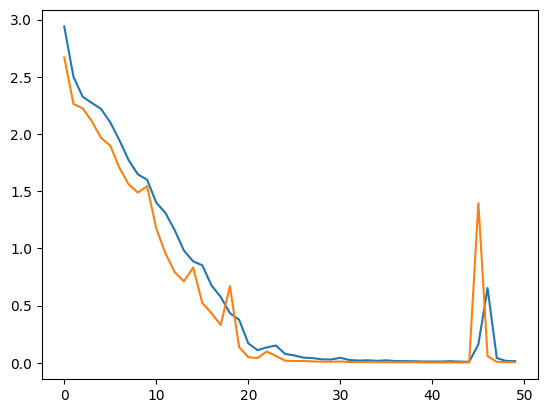

In [20]:
# Plotting
print([sum(x)/len(x) for x in train_losses])
print([sum(x)/len(x) for x in val_losses])
plt.plot([sum(x)/len(x) for x in train_losses])
plt.plot([sum(x)/len(x) for x in val_losses])
print(min([sum(x)/len(x) for x in val_losses]))

In [21]:
# Testing
def test_model(model, test_loader):
    correct = 0
    total = 0
    for data, labels in iter(test_loader):
        data = data.permute((0,2,1)).to(torch.float32).to(device)
        labels = labels.to(device).to(torch.long)
        outputs = model(data)
        _, predicted = torch.max(outputs, dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    return correct / total
        

model_path = "./best_model.pth"
model.to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
accuracy = test_model(model, test_loader)
print(accuracy)

1.0
